In [1]:
# 필요 라이브러리 install
! pip install xgboost
! pip install optuna
! pip install lightgbm

In [2]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
import optuna
from optuna.integration import XGBoostPruningCallback
sns.set_theme(style="darkgrid")

In [3]:
'''from google.colab import drive
drive.mount('/gdrive', force_remount=True)

import pandas as pd

data_file= '/gdrive/My Drive/Colab Notebooks/경로폴더/ml_data.csv'
df= pd.read_csv(data_file) '''

"from google.colab import drive\ndrive.mount('/gdrive', force_remount=True)\n\nimport pandas as pd\n\ndata_file= '/gdrive/My Drive/Colab Notebooks/경로폴더/ml_data.csv'\ndf= pd.read_csv(data_file) "

In [4]:
# 데이터 불러오기
df = pd.read_csv('../data/ML_data.csv')

df

,Unnamed: 0,year,전용면적(㎡)_x,price,employment_rate(%),GDP(won),economysc,consumeprc,migrationpop,bankloan(1bw),...,enc_주교동,enc_주엽동,enc_중산동,enc_지축동,enc_탄현동,enc_토당동,enc_풍동,enc_행신동,enc_향동동,enc_화정동
0,0,2012,59,21356,59.6,1514736.6,92.0,106.30,4562.0,1099781.8,...,0,0,0,0,0,0,0,0,0,0
1,1,2012,84,25238,59.6,1514736.6,92.0,106.30,4562.0,1099781.8,...,0,0,0,0,0,0,0,0,0,0
2,2,2012,101,30607,59.6,1514736.6,92.0,106.30,4562.0,1099781.8,...,0,0,0,0,0,0,0,0,0,0
3,3,2012,124,37333,59.6,1514736.6,92.0,106.30,4562.0,1099781.8,...,0,0,0,0,0,0,0,0,0,0
4,4,2012,153,38075,59.6,1514736.6,92.0,106.30,4562.0,1099781.8,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11306,11306,2021,129,75000,60.5,1910745.0,119.5,118.67,1266.0,2050701.6,...,0,0,0,0,0,0,0,0,0,1
11307,11307,2021,53,41925,60.5,1910745.0,119.5,118.67,1266.0,2050701.6,...,0,0,0,0,0,0,0,0,0,1
11308,11308,2021,59,54263,60.5,1910745.0,119.5,118.67,1266.0,2050701.6,...,0,0,0,0,0,0,0,0,0,1
11309,11309,2021,59,59885,60.5,1910745.0,119.5,118.67,1266.0,2050701.6,...,0,0,0,0,0,0,0,0,0,1


In [5]:
df.drop('Unnamed: 0', axis=1, inplace= True)
df.head(5)

,year,전용면적(㎡)_x,price,employment_rate(%),GDP(won),economysc,consumeprc,migrationpop,bankloan(1bw),room,...,enc_주교동,enc_주엽동,enc_중산동,enc_지축동,enc_탄현동,enc_토당동,enc_풍동,enc_행신동,enc_향동동,enc_화정동
0,2012,59,21356,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0
1,2012,84,25238,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0
2,2012,101,30607,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0
3,2012,124,37333,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0
4,2012,153,38075,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,...,0,0,0,0,0,0,0,0,0,0


In [6]:

# train-test분리
cut = int(len(df)*0.8) # traun, valid 80:20 으로 split
train_tmp = df[:cut]
test = df[cut:]
df = train_tmp

In [7]:
# train 데이터셋 분할

train_X = test.drop('price', axis=1)
train_y = test['price']

print(train_X.shape, train_y.shape)

(2263, 41) (2263,)


In [8]:
# 교차 검증 
# 모델 선정 위해 (XGB, LGB) 모델의 성능 비교
'''
 시계열 데이터 - TimeSeriesSplit 기법을 사용
 10개의 폴드로 구분
  1) 과거의 데이터부터 끊어서 학습
  2) 다음 폴드부터 이전 폴드까지 이용하여 반복적으로 교차검증
  3) 미래의 데이터는 절대 학습하지 않으며 무조건 검증으로 사용됨
'''


def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5 
    return rmse

def rmse_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10) # 10개의 폴드로 구분
    rmse_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return model_name, rmse_list

def print_rmse_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = rmse_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [9]:
# XGB, LGB 모델 설정 
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=9, min_child_weight=5, gamma=0.1, n_jobs=-1)
model_lgb = lgb.LGBMRegressor(n_estimators=500, max_depth=9, min_child_weight=5, n_jobs=-1)

In [10]:
models = []
scores = []
for model in [model_xgb, model_lgb]:
    model_name, mean_score = print_rmse_score(model)
    models.append(model_name)
    scores.append(mean_score)

XGBRegressor Cross Validations...: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]


1 FOLDS: XGBRegressor RMSLE: 33478.8944
2 FOLDS: XGBRegressor RMSLE: 20357.3515
3 FOLDS: XGBRegressor RMSLE: 16343.9286
4 FOLDS: XGBRegressor RMSLE: 12427.5666
5 FOLDS: XGBRegressor RMSLE: 16073.5119
6 FOLDS: XGBRegressor RMSLE: 21682.9299
7 FOLDS: XGBRegressor RMSLE: 12838.6699
8 FOLDS: XGBRegressor RMSLE: 14833.1387
9 FOLDS: XGBRegressor RMSLE: 12317.6392
10 FOLDS: XGBRegressor RMSLE: 11031.2915

XGBRegressor mean RMSLE: 17138.4922


LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

1 FOLDS: LGBMRegressor RMSLE: 33050.9983
2 FOLDS: LGBMRegressor RMSLE: 21518.8780
3 FOLDS: LGBMRegressor RMSLE: 16924.9599
4 FOLDS: LGBMRegressor RMSLE: 10578.7494
5 FOLDS: LGBMRegressor RMSLE: 18648.5488
6 FOLDS: LGBMRegressor RMSLE: 23800.3540
7 FOLDS: LGBMRegressor RMSLE: 16377.1109
8 FOLDS: LGBMRegressor RMSLE: 14961.6031
9 FOLDS: LGBMRegressor RMSLE: 11497.7105
10 FOLDS: LGBMRegressor RMSLE: 11120.2904

LGBMRegressor mean RMSLE: 17847.9203


In [11]:
# 모델 성능 비교
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,XGBRegressor,17138.492225
1,LGBMRegressor,17847.920336


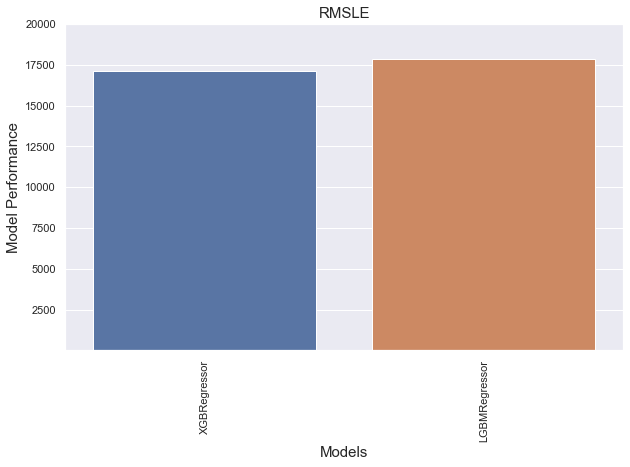

In [12]:
# 모델 성능 시각화하여 확인
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 20000)
plt.title('RMSLE', fontsize=15)
plt.show()

In [13]:
# train, valid split 
cut = int(len(df)*0.8) # traun, valid 80:20 으로 split
train = df[:cut]
valid = df[cut:]

train_X = train.drop('price', axis=1)
train_y = train['price']
valid_X = valid.drop('price', axis=1)
valid_y = valid['price']
print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape)

(7238, 41) (7238,) (1810, 41) (1810,)


In [14]:
train_X.head()

,year,전용면적(㎡)_x,employment_rate(%),GDP(won),economysc,consumeprc,migrationpop,bankloan(1bw),room,bath,...,enc_주교동,enc_주엽동,enc_중산동,enc_지축동,enc_탄현동,enc_토당동,enc_풍동,enc_행신동,enc_향동동,enc_화정동
0,2012,59,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,2,...,0,0,0,0,0,0,0,0,0,0
1,2012,84,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,2,...,0,0,0,0,0,0,0,0,0,0
2,2012,101,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,2,...,0,0,0,0,0,0,0,0,0,0
3,2012,124,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,2,...,0,0,0,0,0,0,0,0,0,0
4,2012,153,59.6,1514736.6,92.0,106.3,4562.0,1099781.8,3,2,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# 하이퍼 파라미터 튜닝
# 시간 이슈 때문에 TimeSeriesSplit은 적용하지 않음
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(train_X, label=train_y)
    dtest = lgb.Dataset(valid_X, label=valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(train_X, train_y, eval_set=[(valid_X, valid_y)], verbose=0, early_stopping_rounds=25)
    rmse = RMSE(valid_y, lgb_model.predict(valid_X))
    return rmse
       
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2022-03-27 13:04:31,787] A new study created in memory with name: no-name-01db2704-9e3b-4021-89a9-1a2e4870c9a6
C:\Users\skaeh\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\skaeh\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-03-27 13:04:35,231] Trial 0 finished with value: 17652.20942725575 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child

In [16]:
# val 검증
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 6448.942782064635,
params {'max_depth': 13, 'learning_rate': 0.005785073410731123, 'n_estimators': 2930, 'min_child_samples': 6, 'subsample': 0.587903658897459}


In [17]:
# test 데이터셋 분할
test_X = test.drop('price', axis=1)
test_y = test['price']

In [18]:
# 데이터에 LightGBM model 적용
final_lgb_model = lgb.LGBMRegressor(**trial_params)
final_lgb_model.fit(train_X, train_y)
final_lgb_pred = final_lgb_model.predict(test_X)

In [19]:
# 평가지표 출력
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print('R2 : {:.3f}'.format(r2_score(test_y, final_lgb_pred)))
print('MSE : {:.3f}'.format(mean_squared_error(test_y, final_lgb_pred)))
print('MAE : {:.3f}'.format(mean_absolute_error(test_y, final_lgb_pred)))
print('RMSE : {:.3f}'.format(np.sqrt(mean_squared_error(test_y, final_lgb_pred))))

R2 : 0.412
MSE : 505457008.959
MAE : 15063.301
RMSE : 22482.371


In [20]:
score = rmse_cv(final_lgb_model)
score

LGBMRegressor Cross Validations...: 100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


('LGBMRegressor',
 [7878.338497952654,
  7382.160054252424,
  4510.143476804088,
  3582.5213268830003,
  3677.8134805351547,
  4113.794430919369,
  3861.6298257559565,
  6379.60007570887,
  4508.225603977606,
  5260.149727606329])

In [21]:
final_lgb_pred

array([42012.61551169, 47491.32274272, 50628.00403891, ...,
       27913.43482753, 27826.27729641, 23335.79601169])

In [22]:
# plt 한글 폰트 깨짐 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

'sudo'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'sudo'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'rm'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [23]:
# 폰트 및 그래프 크기 설정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')
plt.rcParams["figure.figsize"] = [20, 15]

<BarContainer object of 41 artists>

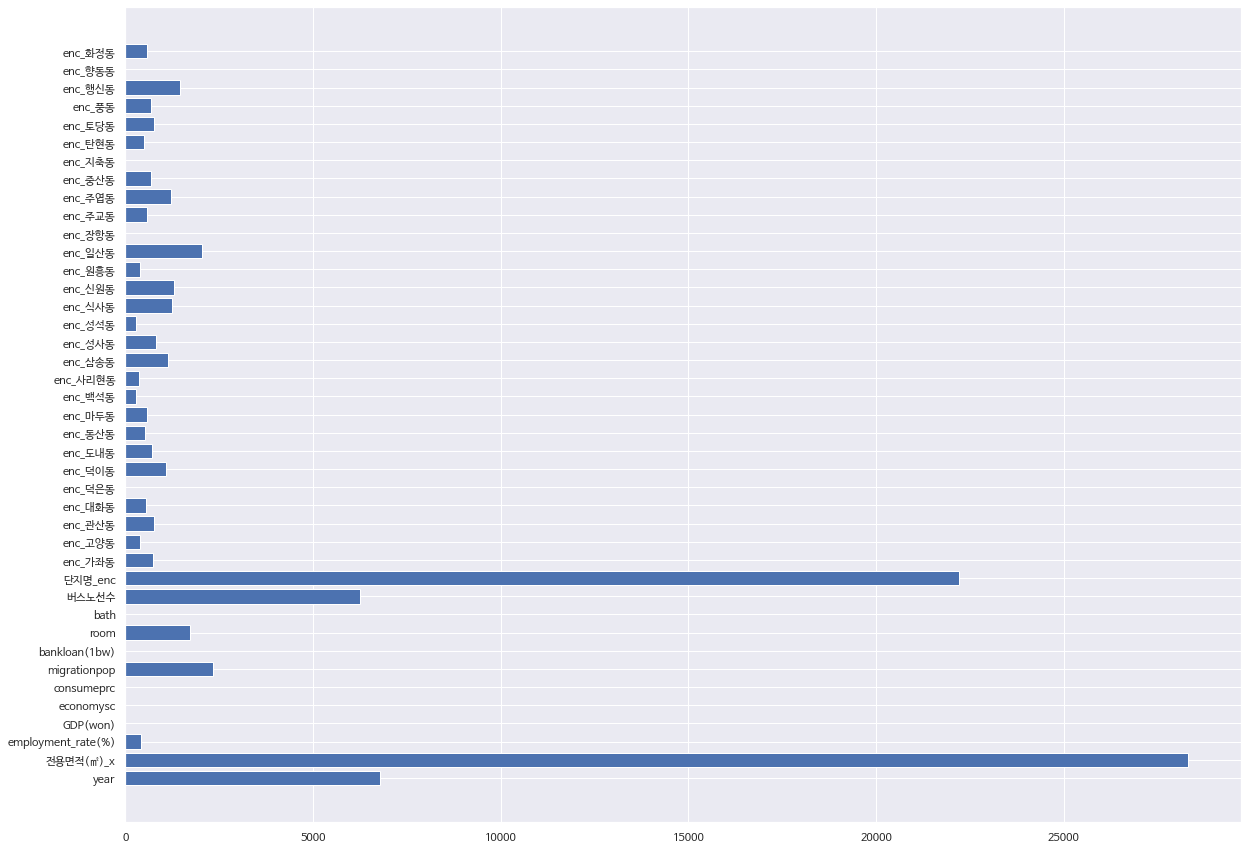

In [24]:
# 그래프 출력
plt.barh(train_X.columns, final_lgb_model.feature_importances_)

# 학습시킨 모델 저장하기
import joblib

joblib.dump(model, './ZDRSJ_model.pkl')

In [25]:
test_X

,year,전용면적(㎡)_x,employment_rate(%),GDP(won),economysc,consumeprc,migrationpop,bankloan(1bw),room,bath,...,enc_주교동,enc_주엽동,enc_중산동,enc_지축동,enc_탄현동,enc_토당동,enc_풍동,enc_행신동,enc_향동동,enc_화정동
9048,2020,84,60.1,1836881.1,114.4,115.78,12353.0,1893716.2,3,2,...,0,0,0,0,0,0,0,0,0,0
9049,2020,101,60.1,1836881.1,114.4,115.78,12353.0,1893716.2,3,2,...,0,0,0,0,0,0,0,0,0,0
9050,2020,134,60.1,1836881.1,114.4,115.78,12353.0,1893716.2,3,2,...,0,0,0,0,0,0,0,0,0,0
9051,2020,50,60.1,1836881.1,114.4,115.78,12353.0,1893716.2,3,2,...,0,0,0,0,0,0,0,0,0,0
9052,2020,70,60.1,1836881.1,114.4,115.78,12353.0,1893716.2,3,2,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11306,2021,129,60.5,1910745.0,119.5,118.67,1266.0,2050701.6,3,2,...,0,0,0,0,0,0,0,0,0,1
11307,2021,53,60.5,1910745.0,119.5,118.67,1266.0,2050701.6,3,2,...,0,0,0,0,0,0,0,0,0,1
11308,2021,59,60.5,1910745.0,119.5,118.67,1266.0,2050701.6,3,2,...,0,0,0,0,0,0,0,0,0,1
11309,2021,59,60.5,1910745.0,119.5,118.67,1266.0,2050701.6,3,2,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
입력값 > 데이터값을 데이터 프레임으로 변환(컬럼 지정) >모델에 넣어주기

In [ ]:
test_pred = final_lgb_model.predict(test_X)
